# 1. Import packages and Global parameters setting

In [1]:

from sklearn import datasets
iris = datasets.load_iris()

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt

from copy import deepcopy

ITERATIONS = 10
CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

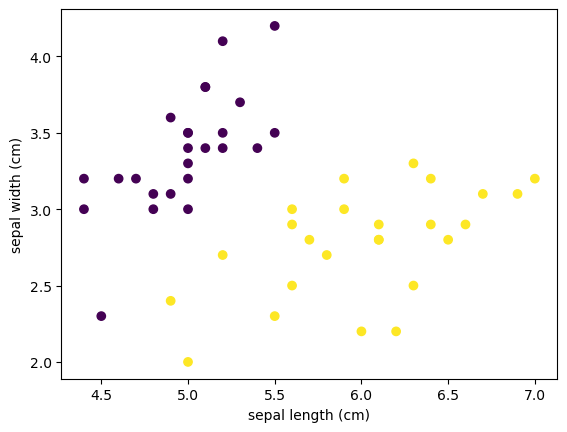

In [2]:
# remove virginica class
data_X = iris.data[iris.target != 2]
data_X = data_X[:, :2]  # only 2 features
# 1 if class is virginica, -1 if class is setosa
data_y = np.array([1 if i == 1 else -1 for i in iris.target[iris.target != 2]])

num_samples = 50
tot_samples = len(data_X)

data_X = data_X[tot_samples // 2 - num_samples // 2:tot_samples // 2 + num_samples // 2]
data_y = data_y[tot_samples // 2 - num_samples // 2:tot_samples // 2 + num_samples // 2]

_, ax = plt.subplots()
scatter = ax.scatter(data_X[:, 0], data_X[:, 1], c=data_y)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

In [3]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

g = [-data_y[i] * (w @ data_X[i] + b) + 1 <= 0.0 for i in range(data_y.shape[0])]

problem = cp.Problem(objective, g)

t0 = time.time()
problem.solve(solver='SCS')
print('time: ' + str(time.time()-t0))
print(problem.value)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

time: 0.1125788688659668
33.79501385000456
Optimal w:  [ 6.31578947 -5.26315789]
Optimal b:  [-17.31578947]


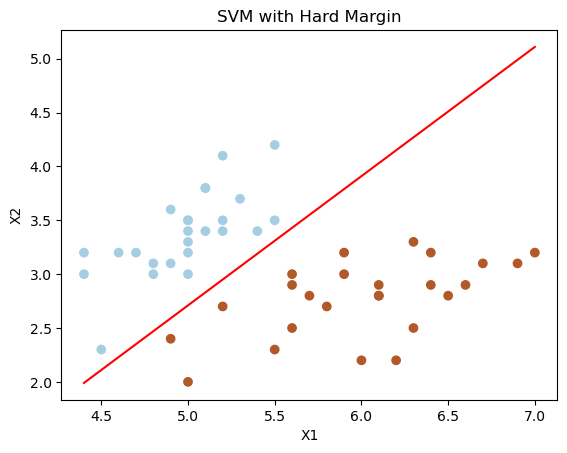

In [4]:
w_op = w.value
b_op = b.value

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_op[0] / w_op[1]) * x_plot - b_op / w_op[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# 2. The 5th NCP

In [5]:
nx = data_X.shape[1] + 1
nu = data_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:-1]
    b = x[-1]
    
    g = [-data_y[i] * (w @ data_X[i] + b) + 1 for i in range(data_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

In [8]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:3].set(1.0)

sol = solve_ivp(ODE, [0., 500.], xu0, t_eval=np.arange(0, 500, 0.01), method=NUMERICAL_METHOD)
result = P(sol.y[:, -1])
print(evalutation(result))
print(result)


33.709545
[  6.30750128  -5.25685492 -17.29163794   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           7.19262931
   0.           0.           0.           0.          26.56318135
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
  33.75532433   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.        ]


In [10]:
evalutation(result)

Array(33.709545, dtype=float32)

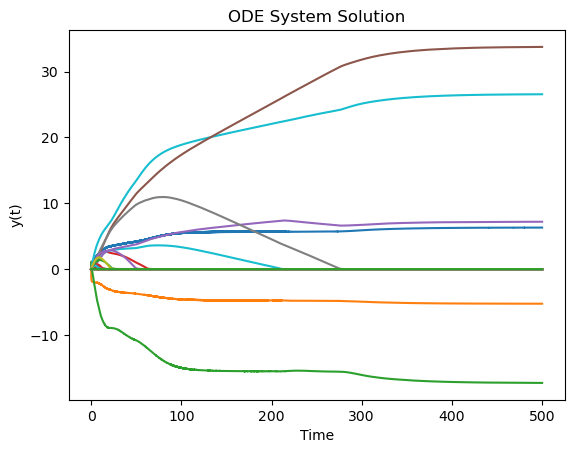

In [9]:
t_values = sol.t
y_values = sol.y

plt.plot(t_values, y_values.T)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('ODE System Solution')
plt.show()

In [11]:
w_op = w.value
b_op = b.value

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

w_1_abs_diff = np.abs(w_op[0] - w_ode[0])
w_2_abs_diff = np.abs(w_op[1] - w_ode[1])
b_abs_diff = np.abs(b_op[0] - b_ode)

# Calculate the squared differences
w_1_sq_diff = w_1_abs_diff ** 2
w_2_sq_diff = w_2_abs_diff ** 2
b_sq_diff = b_abs_diff ** 2

mse_ = (w_1_sq_diff + w_2_sq_diff + b_sq_diff) / 3

print('w_1 absolute difference:', w_1_abs_diff)
print('w_2 absolute difference:', w_2_abs_diff)
print('b absolute difference:', b_abs_diff)

print('\nMSE between the two solutions:', mse_)

w_1 absolute difference: 0.008288189954869907
w_2 absolute difference: 0.006302971959433634
b absolute difference: 0.024151536976216192

MSE between the two solutions: 0.00023057276218765038


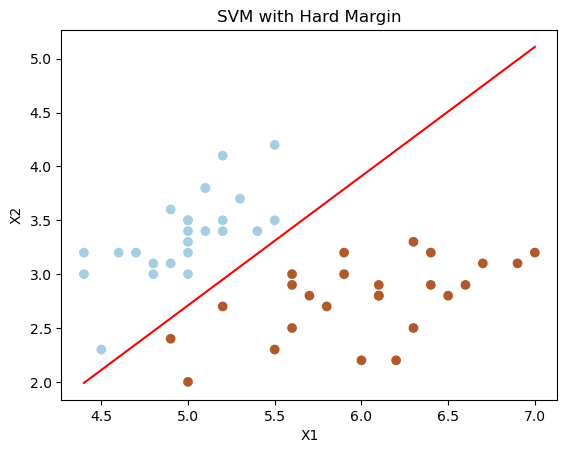

In [12]:
w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_ode[0] / w_ode[1]) * x_plot - b_ode / w_ode[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [13]:
x, u = result[:nx], result[nx:]
error1 = df(x)+u@dg(x)
error1 = np.max(np.abs((error1)))
error2 = u-np.clip(u+g(x),a_min=0,a_max=None)
error2 = np.max(np.abs((error2)))
print(error1, error2)


0.0004844656 0.0013518825006109125


# 3. The method

In [14]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if CUDA:
            net = net.cuda()
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss

    def loss_compute(self, t, net, weighting=0.5):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # Compute loss, torch.tensor a float
        loss = mse(dy, pdy) # [NBATCH, NY]
        loss = torch.sum(loss, axis=1) # [NBATCH]
        if weighting is not None:
            loss = torch.exp(-weighting*t.detach().reshape((-1, )))*loss # proprity smaller t
        loss = torch.mean(loss, axis=0)
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [16]:
y0 = np.zeros(NY)
y0[:3] = 1.0

In [17]:
NBATCH = 512 * 5 # 512
ITERATIONS = 1000

In [18]:
NEURONS = 500
LAYERS = 1
LR = 0.01
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 10722.8779,  epsilon_best: inf, y_T: [ 0.7499  0.3923  0.2467  1.2473  0.5183  0.3255  0.4187  0.913  -0.7066
 -0.8725  0.179  -0.542  -0.1803 -0.0371  0.4428  0.3905  0.7842  0.9733
 -0.3287  0.1232  0.0085  1.0375 -0.4441 -0.6174  0.359   0.0364 -0.1711
  0.5457 -0.0311  1.0725 -0.0515 -1.0482 -0.0443  0.034   0.5566  0.1414
 -0.6944 -0.6197 -0.4824 -0.878  -0.349   0.0504 -0.5563  0.1508  0.9745
  0.2439  0.6028 -0.5435 -1.4132 -0.3756  1.2999 -0.9398  0.086 ]
T: 500, Iteration: 100, Loss: 6487.5386,  epsilon_best: inf, y_T: [ 0.7499  0.3923  0.2467  1.2473  0.5183  0.3255  0.4187  0.913  -0.7066
 -0.8725  0.179  -0.542  -0.1803 -0.0371  0.4428  0.3905  0.7842  0.9733
 -0.3287  0.1232  0.0085  1.0375 -0.4441 -0.6174  0.359   0.0364 -0.1711
  0.5457 -0.0311  1.0725 -0.0515 -1.0482 -0.0443  0.034   0.5566  0.1414
 -0.6944 -0.6197 -0.4824 -0.878  -0.349   0.0504 -0.5563  0.1508  0.9745
  0.2439  0.6028 -0.5435 -1.4132 -0.3756  1.2999 -0.9398  0.086 ]
T: 500,

In [19]:
LAYERS = 2
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_2 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 10820.8926,  epsilon_best: inf, y_T: [ 0.8629  1.2392  1.1829  0.0701  0.0948 -0.1367  0.0536  0.0598 -0.3516
  0.2452 -0.0315  0.0785 -0.0167  0.229  -0.0556 -0.2597 -0.1853 -0.0822
 -0.2265  0.4026 -0.6631  0.0003  0.0792  0.157   0.2251 -0.3051 -0.1065
  0.117  -0.0256 -0.1199 -0.2443 -0.4028  0.349   0.2192 -0.1273 -0.3881
 -0.2628 -0.1402 -0.0827 -0.0488  0.2109  0.3858  0.1992 -0.334   0.0872
  0.1139  0.0598 -0.0708 -0.1977  0.2427  0.0338 -0.2107  0.1622]


T: 500, Iteration: 100, Loss: 1259.9349,  epsilon_best: inf, y_T: [ 0.8629  1.2392  1.1829  0.0701  0.0948 -0.1367  0.0536  0.0598 -0.3516
  0.2452 -0.0315  0.0785 -0.0167  0.229  -0.0556 -0.2597 -0.1853 -0.0822
 -0.2265  0.4026 -0.6631  0.0003  0.0792  0.157   0.2251 -0.3051 -0.1065
  0.117  -0.0256 -0.1199 -0.2443 -0.4028  0.349   0.2192 -0.1273 -0.3881
 -0.2628 -0.1402 -0.0827 -0.0488  0.2109  0.3858  0.1992 -0.334   0.0872
  0.1139  0.0598 -0.0708 -0.1977  0.2427  0.0338 -0.2107  0.1622]
T: 500, Iteration: 200, Loss: 2435.4360,  epsilon_best: inf, y_T: [ 0.8629  1.2392  1.1829  0.0701  0.0948 -0.1367  0.0536  0.0598 -0.3516
  0.2452 -0.0315  0.0785 -0.0167  0.229  -0.0556 -0.2597 -0.1853 -0.0822
 -0.2265  0.4026 -0.6631  0.0003  0.0792  0.157   0.2251 -0.3051 -0.1065
  0.117  -0.0256 -0.1199 -0.2443 -0.4028  0.349   0.2192 -0.1273 -0.3881
 -0.2628 -0.1402 -0.0827 -0.0488  0.2109  0.3858  0.1992 -0.334   0.0872
  0.1139  0.0598 -0.0708 -0.1977  0.2427  0.0338 -0.2107  0.1622]
T: 500

In [20]:
LAYERS = 3
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_3 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 9908.8467,  epsilon_best: inf, y_T: [ 1.0926  1.058   1.131  -0.381   0.2006 -0.1821 -0.0499 -0.0002  0.1785
  0.1991  0.0831  0.1119 -0.039  -0.1702 -0.2063  0.0672  0.3085 -0.1193
  0.0616  0.0474  0.0953  0.1599 -0.0138  0.0684 -0.0123  0.1696  0.3024
  0.2487 -0.378   0.0249 -0.0948 -0.0344 -0.0911  0.0742 -0.0653  0.3718
  0.1929  0.0019 -0.258   0.0796 -0.2897  0.0487  0.0659 -0.1825 -0.014
  0.0237  0.0329 -0.1828  0.0082 -0.1071 -0.3712 -0.0971  0.0239]


T: 500, Iteration: 100, Loss: 2155.7734,  epsilon_best: inf, y_T: [ 1.0926  1.058   1.131  -0.381   0.2006 -0.1821 -0.0499 -0.0002  0.1785
  0.1991  0.0831  0.1119 -0.039  -0.1702 -0.2063  0.0672  0.3085 -0.1193
  0.0616  0.0474  0.0953  0.1599 -0.0138  0.0684 -0.0123  0.1696  0.3024
  0.2487 -0.378   0.0249 -0.0948 -0.0344 -0.0911  0.0742 -0.0653  0.3718
  0.1929  0.0019 -0.258   0.0796 -0.2897  0.0487  0.0659 -0.1825 -0.014
  0.0237  0.0329 -0.1828  0.0082 -0.1071 -0.3712 -0.0971  0.0239]
T: 500, Iteration: 200, Loss: 50071.7109,  epsilon_best: inf, y_T: [ 1.0926  1.058   1.131  -0.381   0.2006 -0.1821 -0.0499 -0.0002  0.1785
  0.1991  0.0831  0.1119 -0.039  -0.1702 -0.2063  0.0672  0.3085 -0.1193
  0.0616  0.0474  0.0953  0.1599 -0.0138  0.0684 -0.0123  0.1696  0.3024
  0.2487 -0.378   0.0249 -0.0948 -0.0344 -0.0911  0.0742 -0.0653  0.3718
  0.1929  0.0019 -0.258   0.0796 -0.2897  0.0487  0.0659 -0.1825 -0.014
  0.0237  0.0329 -0.1828  0.0082 -0.1071 -0.3712 -0.0971  0.0239]
T: 500,

In [21]:
LAYERS = 4
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_L_4 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 9839.0732,  epsilon_best: inf, y_T: [ 1.0697  0.9952  1.0413  0.2333 -0.0828 -0.017  -0.0033 -0.0758  0.2365
  0.0716 -0.0162 -0.1009  0.0321 -0.0056 -0.0186  0.101  -0.0174  0.0365
 -0.0617  0.0869 -0.1378 -0.1267 -0.1013  0.0586 -0.0238 -0.0645 -0.0458
 -0.2122 -0.0906  0.0311  0.0672 -0.0523 -0.1054  0.0525  0.1538  0.0589
 -0.0174  0.0895 -0.1457  0.0355 -0.0325  0.0621  0.0448  0.0913  0.1311
 -0.1036 -0.1577 -0.0599  0.0306  0.0783  0.0647  0.1283 -0.026 ]


T: 500, Iteration: 100, Loss: 1484.5863,  epsilon_best: inf, y_T: [ 1.0697  0.9952  1.0413  0.2333 -0.0828 -0.017  -0.0033 -0.0758  0.2365
  0.0716 -0.0162 -0.1009  0.0321 -0.0056 -0.0186  0.101  -0.0174  0.0365
 -0.0617  0.0869 -0.1378 -0.1267 -0.1013  0.0586 -0.0238 -0.0645 -0.0458
 -0.2122 -0.0906  0.0311  0.0672 -0.0523 -0.1054  0.0525  0.1538  0.0589
 -0.0174  0.0895 -0.1457  0.0355 -0.0325  0.0621  0.0448  0.0913  0.1311
 -0.1036 -0.1577 -0.0599  0.0306  0.0783  0.0647  0.1283 -0.026 ]
T: 500, Iteration: 200, Loss: 2064.7107,  epsilon_best: inf, y_T: [ 1.0697  0.9952  1.0413  0.2333 -0.0828 -0.017  -0.0033 -0.0758  0.2365
  0.0716 -0.0162 -0.1009  0.0321 -0.0056 -0.0186  0.101  -0.0174  0.0365
 -0.0617  0.0869 -0.1378 -0.1267 -0.1013  0.0586 -0.0238 -0.0645 -0.0458
 -0.2122 -0.0906  0.0311  0.0672 -0.0523 -0.1054  0.0525  0.1538  0.0589
 -0.0174  0.0895 -0.1457  0.0355 -0.0325  0.0621  0.0448  0.0913  0.1311
 -0.1036 -0.1577 -0.0599  0.0306  0.0783  0.0647  0.1283 -0.026 ]
T: 500

In [22]:
NEURONS = 100
LAYERS = 1
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_1 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 18927.4844,  epsilon_best: inf, y_T: [ 1.2194  1.9067  1.0523 -0.0312 -0.7396  0.4953  0.2773  0.3285  0.9288
  0.0902 -0.5554 -0.1689  0.1942  0.4975 -0.5057  0.0938 -0.9088 -0.409
  0.1224  0.0198  0.147   0.3727  0.1989 -0.9166  0.7478  0.2003 -0.5768
  0.4056  0.6624 -0.3478  0.7096  0.3303 -0.0756  0.8972  0.9559  0.7122
 -0.5044 -0.1783 -0.5232  0.4245  0.1122  0.7534  0.6434  0.6978 -0.0341
  0.938  -0.2309  0.1403 -0.4654 -0.4113  0.3839  0.2199  1.3922]
T: 500, Iteration: 100, Loss: 1733.9305,  epsilon_best: inf, y_T: [ 1.2194  1.9067  1.0523 -0.0312 -0.7396  0.4953  0.2773  0.3285  0.9288
  0.0902 -0.5554 -0.1689  0.1942  0.4975 -0.5057  0.0938 -0.9088 -0.409
  0.1224  0.0198  0.147   0.3727  0.1989 -0.9166  0.7478  0.2003 -0.5768
  0.4056  0.6624 -0.3478  0.7096  0.3303 -0.0756  0.8972  0.9559  0.7122
 -0.5044 -0.1783 -0.5232  0.4245  0.1122  0.7534  0.6434  0.6978 -0.0341
  0.938  -0.2309  0.1403 -0.4654 -0.4113  0.3839  0.2199  1.3922]


T: 500, Iteration: 200, Loss: 1753.6172,  epsilon_best: inf, y_T: [ 1.2194  1.9067  1.0523 -0.0312 -0.7396  0.4953  0.2773  0.3285  0.9288
  0.0902 -0.5554 -0.1689  0.1942  0.4975 -0.5057  0.0938 -0.9088 -0.409
  0.1224  0.0198  0.147   0.3727  0.1989 -0.9166  0.7478  0.2003 -0.5768
  0.4056  0.6624 -0.3478  0.7096  0.3303 -0.0756  0.8972  0.9559  0.7122
 -0.5044 -0.1783 -0.5232  0.4245  0.1122  0.7534  0.6434  0.6978 -0.0341
  0.938  -0.2309  0.1403 -0.4654 -0.4113  0.3839  0.2199  1.3922]
T: 500, Iteration: 300, Loss: 591.2662,  epsilon_best: inf, y_T: [ 1.2194  1.9067  1.0523 -0.0312 -0.7396  0.4953  0.2773  0.3285  0.9288
  0.0902 -0.5554 -0.1689  0.1942  0.4975 -0.5057  0.0938 -0.9088 -0.409
  0.1224  0.0198  0.147   0.3727  0.1989 -0.9166  0.7478  0.2003 -0.5768
  0.4056  0.6624 -0.3478  0.7096  0.3303 -0.0756  0.8972  0.9559  0.7122
 -0.5044 -0.1783 -0.5232  0.4245  0.1122  0.7534  0.6434  0.6978 -0.0341
  0.938  -0.2309  0.1403 -0.4654 -0.4113  0.3839  0.2199  1.3922]
T: 500, I

In [23]:
NEURONS = 300
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_3 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 4358.7788,  epsilon_best: inf, y_T: [ 0.51    0.9115  1.1857  0.837  -0.2815 -0.388   0.0484 -1.262   0.3025
  1.2155  1.0482 -0.1378  1.0434 -0.7902 -0.6586  0.2278 -0.4165 -0.0057
  0.068   0.5443 -0.5494  0.0519  0.0128  0.0377  0.8991 -0.0686  0.047
 -1.3209 -1.1028  0.351  -0.1561 -0.8622 -0.0846 -0.5161  0.0538  0.8604
 -0.4865  0.8754 -0.3933  0.0781 -0.4254 -0.3472  0.0217  0.6178  0.2363
 -0.3737  0.1156  0.4336  0.5916 -0.1422 -0.6924 -0.0176 -0.778 ]
T: 500, Iteration: 100, Loss: 159.3970,  epsilon_best: inf, y_T: [ 0.51    0.9115  1.1857  0.837  -0.2815 -0.388   0.0484 -1.262   0.3025
  1.2155  1.0482 -0.1378  1.0434 -0.7902 -0.6586  0.2278 -0.4165 -0.0057
  0.068   0.5443 -0.5494  0.0519  0.0128  0.0377  0.8991 -0.0686  0.047
 -1.3209 -1.1028  0.351  -0.1561 -0.8622 -0.0846 -0.5161  0.0538  0.8604
 -0.4865  0.8754 -0.3933  0.0781 -0.4254 -0.3472  0.0217  0.6178  0.2363
 -0.3737  0.1156  0.4336  0.5916 -0.1422 -0.6924 -0.0176 -0.778 ]
T: 500, Ite

T: 500, Iteration: 300, Loss: 150.8286,  epsilon_best: inf, y_T: [ 0.51    0.9115  1.1857  0.837  -0.2815 -0.388   0.0484 -1.262   0.3025
  1.2155  1.0482 -0.1378  1.0434 -0.7902 -0.6586  0.2278 -0.4165 -0.0057
  0.068   0.5443 -0.5494  0.0519  0.0128  0.0377  0.8991 -0.0686  0.047
 -1.3209 -1.1028  0.351  -0.1561 -0.8622 -0.0846 -0.5161  0.0538  0.8604
 -0.4865  0.8754 -0.3933  0.0781 -0.4254 -0.3472  0.0217  0.6178  0.2363
 -0.3737  0.1156  0.4336  0.5916 -0.1422 -0.6924 -0.0176 -0.778 ]
T: 500, Iteration: 400, Loss: 2493.1497,  epsilon_best: inf, y_T: [ 0.51    0.9115  1.1857  0.837  -0.2815 -0.388   0.0484 -1.262   0.3025
  1.2155  1.0482 -0.1378  1.0434 -0.7902 -0.6586  0.2278 -0.4165 -0.0057
  0.068   0.5443 -0.5494  0.0519  0.0128  0.0377  0.8991 -0.0686  0.047
 -1.3209 -1.1028  0.351  -0.1561 -0.8622 -0.0846 -0.5161  0.0538  0.8604
 -0.4865  0.8754 -0.3933  0.0781 -0.4254 -0.3472  0.0217  0.6178  0.2363
 -0.3737  0.1156  0.4336  0.5916 -0.1422 -0.6924 -0.0176 -0.778 ]
T: 500, I

In [24]:
NEURONS = 500
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_5 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 7412.9858,  epsilon_best: inf, y_T: [ 1.3285  1.4654  1.2486 -0.7579 -0.2501 -0.3582  0.7507  0.5123  0.128
 -0.4447  0.1044  0.5244  0.1718  0.1215 -1.7465  0.4994 -0.7734 -0.0212
  0.1571  0.6971  0.4743 -1.1448  0.2512  0.7516  1.108   0.1035 -0.4135
  0.5548 -0.2062  0.3779  0.1401 -0.7166 -0.8135 -0.757   0.1499 -0.1063
  1.1661  0.6863 -0.544   0.7111  0.2774  0.4862 -0.8823 -0.4856 -0.2128
 -0.3806 -0.2896 -0.1139  0.5559  0.2517  0.4357 -0.0199 -0.2638]


T: 500, Iteration: 100, Loss: 136.6912,  epsilon_best: inf, y_T: [ 1.3285  1.4654  1.2486 -0.7579 -0.2501 -0.3582  0.7507  0.5123  0.128
 -0.4447  0.1044  0.5244  0.1718  0.1215 -1.7465  0.4994 -0.7734 -0.0212
  0.1571  0.6971  0.4743 -1.1448  0.2512  0.7516  1.108   0.1035 -0.4135
  0.5548 -0.2062  0.3779  0.1401 -0.7166 -0.8135 -0.757   0.1499 -0.1063
  1.1661  0.6863 -0.544   0.7111  0.2774  0.4862 -0.8823 -0.4856 -0.2128
 -0.3806 -0.2896 -0.1139  0.5559  0.2517  0.4357 -0.0199 -0.2638]
T: 500, Iteration: 200, Loss: 18132.0137,  epsilon_best: inf, y_T: [ 1.3285  1.4654  1.2486 -0.7579 -0.2501 -0.3582  0.7507  0.5123  0.128
 -0.4447  0.1044  0.5244  0.1718  0.1215 -1.7465  0.4994 -0.7734 -0.0212
  0.1571  0.6971  0.4743 -1.1448  0.2512  0.7516  1.108   0.1035 -0.4135
  0.5548 -0.2062  0.3779  0.1401 -0.7166 -0.8135 -0.757   0.1499 -0.1063
  1.1661  0.6863 -0.544   0.7111  0.2774  0.4862 -0.8823 -0.4856 -0.2128
 -0.3806 -0.2896 -0.1139  0.5559  0.2517  0.4357 -0.0199 -0.2638]
T: 500, 

In [25]:
NEURONS = 700
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_7 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 8909.7051,  epsilon_best: inf, y_T: [ 0.7049  0.8547  0.4759  2.2325 -0.1574 -0.3335  0.2615  0.4543 -0.0222
  0.289  -0.025   0.0426 -0.4255 -0.435   0.4216  1.1585 -0.0294 -0.4953
  0.4802 -0.0117  0.2801  0.0405  0.158  -0.6692 -0.0157 -0.9282 -0.316
  0.1719 -1.332  -0.7841 -0.473  -0.7623  0.3634  1.101   0.5077 -0.2917
 -0.2616  0.6705 -0.3972  0.2024  0.3658  0.3103 -0.0598 -0.7109 -0.5543
  0.4719  1.1033 -0.788  -0.357  -0.4944 -0.1562 -0.6386 -0.3857]


T: 500, Iteration: 100, Loss: 11495.8301,  epsilon_best: inf, y_T: [ 0.7049  0.8547  0.4759  2.2325 -0.1574 -0.3335  0.2615  0.4543 -0.0222
  0.289  -0.025   0.0426 -0.4255 -0.435   0.4216  1.1585 -0.0294 -0.4953
  0.4802 -0.0117  0.2801  0.0405  0.158  -0.6692 -0.0157 -0.9282 -0.316
  0.1719 -1.332  -0.7841 -0.473  -0.7623  0.3634  1.101   0.5077 -0.2917
 -0.2616  0.6705 -0.3972  0.2024  0.3658  0.3103 -0.0598 -0.7109 -0.5543
  0.4719  1.1033 -0.788  -0.357  -0.4944 -0.1562 -0.6386 -0.3857]
T: 500, Iteration: 200, Loss: 1433.8252,  epsilon_best: inf, y_T: [ 0.7049  0.8547  0.4759  2.2325 -0.1574 -0.3335  0.2615  0.4543 -0.0222
  0.289  -0.025   0.0426 -0.4255 -0.435   0.4216  1.1585 -0.0294 -0.4953
  0.4802 -0.0117  0.2801  0.0405  0.158  -0.6692 -0.0157 -0.9282 -0.316
  0.1719 -1.332  -0.7841 -0.473  -0.7623  0.3634  1.101   0.5077 -0.2917
 -0.2616  0.6705 -0.3972  0.2024  0.3658  0.3103 -0.0598 -0.7109 -0.5543
  0.4719  1.1033 -0.788  -0.357  -0.4944 -0.1562 -0.6386 -0.3857]
T: 500,

In [26]:
NEURONS = 900
example = NN_NOP(y0, [0, 500], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_N_9 = {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 500, Iteration: 0, Loss: 18677.0605,  epsilon_best: inf, y_T: [ 1.267   2.1956  0.5881 -0.0974  0.2354  1.0556  0.3648 -0.2025  0.9913
  0.8227 -0.6799  0.8614 -0.3014 -0.3957  0.0628  0.158   0.5821  1.9853
 -0.9613  0.2604 -0.8005  0.0248  0.4373  0.3941 -0.3144 -0.2066 -0.1646
  0.264  -0.4728 -0.3438 -1.1672  0.2383 -0.3607  0.2669 -0.2532  1.7256
 -0.11   -0.5782  0.2014  1.3358 -0.6527 -0.5985 -0.4606  0.7863  0.0319
 -0.7816 -0.3497  0.2772  0.3272  0.2492  0.4722  0.142   0.1188]


T: 500, Iteration: 100, Loss: 1326.6187,  epsilon_best: inf, y_T: [ 1.267   2.1956  0.5881 -0.0974  0.2354  1.0556  0.3648 -0.2025  0.9913
  0.8227 -0.6799  0.8614 -0.3014 -0.3957  0.0628  0.158   0.5821  1.9853
 -0.9613  0.2604 -0.8005  0.0248  0.4373  0.3941 -0.3144 -0.2066 -0.1646
  0.264  -0.4728 -0.3438 -1.1672  0.2383 -0.3607  0.2669 -0.2532  1.7256
 -0.11   -0.5782  0.2014  1.3358 -0.6527 -0.5985 -0.4606  0.7863  0.0319
 -0.7816 -0.3497  0.2772  0.3272  0.2492  0.4722  0.142   0.1188]
T: 500, Iteration: 200, Loss: 11283.8535,  epsilon_best: inf, y_T: [ 1.267   2.1956  0.5881 -0.0974  0.2354  1.0556  0.3648 -0.2025  0.9913
  0.8227 -0.6799  0.8614 -0.3014 -0.3957  0.0628  0.158   0.5821  1.9853
 -0.9613  0.2604 -0.8005  0.0248  0.4373  0.3941 -0.3144 -0.2066 -0.1646
  0.264  -0.4728 -0.3438 -1.1672  0.2383 -0.3607  0.2669 -0.2532  1.7256
 -0.11   -0.5782  0.2014  1.3358 -0.6527 -0.5985 -0.4606  0.7863  0.0319
 -0.7816 -0.3497  0.2772  0.3272  0.2492  0.4722  0.142   0.1188]
T: 50

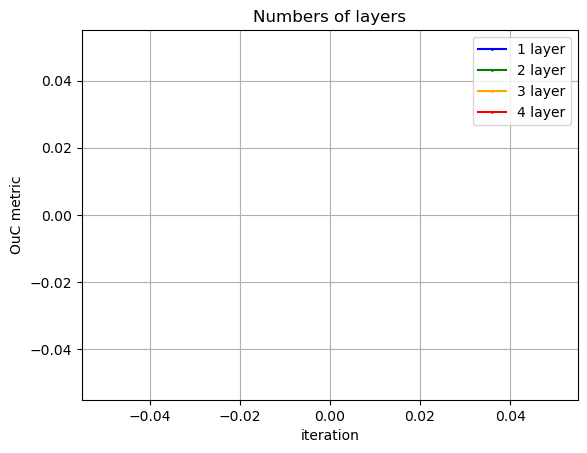

In [27]:
# Plot each dataset with labels
plt.plot(res_L_1['L_epsilon'], marker='o', linestyle='-', color='blue', label='1 layer', markersize=1)
plt.plot(res_L_2['L_epsilon'], marker='o', linestyle='-', color='green', label='2 layer', markersize=1)
plt.plot(res_L_3['L_epsilon'], marker='o', linestyle='-', color='orange', label='3 layer', markersize=1)
plt.plot(res_L_4['L_epsilon'], marker='o', linestyle='-', color='red', label='4 layer', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Numbers of layers')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()


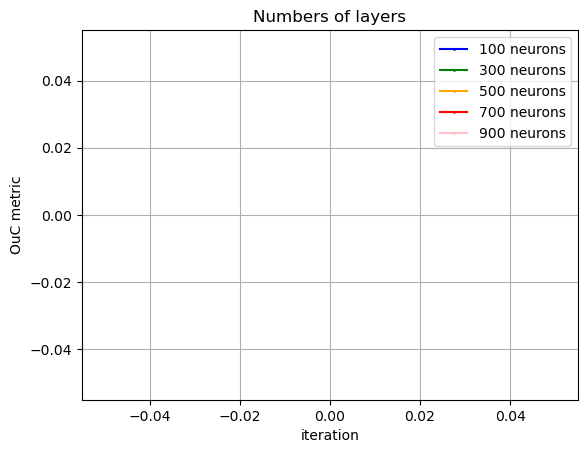

In [28]:
# Plot each dataset with labels
plt.plot(res_N_1['L_epsilon'], marker='o', linestyle='-', color='blue', label='100 neurons', markersize=1)
plt.plot(res_N_3['L_epsilon'], marker='o', linestyle='-', color='green', label='300 neurons', markersize=1)
plt.plot(res_N_5['L_epsilon'], marker='o', linestyle='-', color='orange', label='500 neurons', markersize=1)
plt.plot(res_N_7['L_epsilon'], marker='o', linestyle='-', color='red', label='700 neurons', markersize=1)
plt.plot(res_N_9['L_epsilon'], marker='o', linestyle='-', color='pink', label='900 neurons', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('Numbers of layers')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

In [26]:
NEURONS = 100
LAYERS = 4
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_1= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2292.4805,  epsilon_best: inf, y_T: [ 1.1362  1.025   1.0417  0.0431  0.0706 -0.1151 -0.0049 -0.0164  0.0208
  0.0173  0.0554  0.0499  0.0254]
T: 100, Iteration: 100, Loss: 383.7516,  epsilon_best: inf, y_T: [ 1.1362  1.025   1.0417  0.0431  0.0706 -0.1151 -0.0049 -0.0164  0.0208
  0.0173  0.0554  0.0499  0.0254]
T: 100, Iteration: 200, Loss: 546.1545,  epsilon_best: inf, y_T: [ 1.1362  1.025   1.0417  0.0431  0.0706 -0.1151 -0.0049 -0.0164  0.0208
  0.0173  0.0554  0.0499  0.0254]
T: 100, Iteration: 300, Loss: 875.9193,  epsilon_best: 7.7645, y_T: [ 2.0441 -3.369  -0.7129  0.4644  0.4228  0.3426  0.5326  0.4762  3.0648
  3.271   2.983   2.7387  2.8397]
T: 100, Iteration: 400, Loss: 63.1641,  epsilon_best: 7.7645, y_T: [ 2.0441 -3.369  -0.7129  0.4644  0.4228  0.3426  0.5326  0.4762  3.0648
  3.271   2.983   2.7387  2.8397]
T: 100, Iteration: 500, Loss: 621.9955,  epsilon_best: 7.7645, y_T: [ 2.0441 -3.369  -0.7129  0.4644  0.4228  0.3426  0.5326  0.4762  3.

In [30]:
NEURONS = 100
LAYERS = 3
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_2= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 2339.7852,  epsilon_best: inf, y_T: [ 0.995   0.9483  1.1503  0.0475 -0.0857  0.2315  0.203  -0.1775  0.0726
 -0.1191 -0.0929 -0.0077 -0.1082]
T: 100, Iteration: 100, Loss: 355.6003,  epsilon_best: inf, y_T: [ 0.995   0.9483  1.1503  0.0475 -0.0857  0.2315  0.203  -0.1775  0.0726
 -0.1191 -0.0929 -0.0077 -0.1082]
T: 100, Iteration: 200, Loss: 580.6634,  epsilon_best: 7.3527, y_T: [ 2.0236 -3.2574 -1.0148  1.1639  0.9986  0.9285  1.1716  1.0891  2.276
  2.5885  2.2456  2.0001  2.069 ]
T: 100, Iteration: 300, Loss: 188.8868,  epsilon_best: 7.3527, y_T: [ 2.0236 -3.2574 -1.0148  1.1639  0.9986  0.9285  1.1716  1.0891  2.276
  2.5885  2.2456  2.0001  2.069 ]
T: 100, Iteration: 400, Loss: 92.8531,  epsilon_best: 7.3527, y_T: [ 2.0236 -3.2574 -1.0148  1.1639  0.9986  0.9285  1.1716  1.0891  2.276
  2.5885  2.2456  2.0001  2.069 ]
T: 100, Iteration: 500, Loss: 898.3272,  epsilon_best: 7.3527, y_T: [ 2.0236 -3.2574 -1.0148  1.1639  0.9986  0.9285  1.1716  1.0891  2.

In [31]:
NEURONS = 300
LAYERS = 3
LR = 0.01
example = NN_NOP(y0, [0, 100], P, ODE, evalutation) # init
L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss = example.NN_method() # train
res_3= {
    'L_epsilon': L_epsilon,
    'L_epsilon_curr': L_epsilon_curr,
    'L_y_T': L_y_T,
    'L_y_T_curr': L_y_T_curr,
    'net_best': net_best,
    'L_loss': L_loss,
    'IP': y0
}

T: 100, Iteration: 0, Loss: 1550.4730,  epsilon_best: inf, y_T: [ 1.0365  0.9936  1.106   0.0735  0.1039 -0.1028  0.032  -0.0945 -0.0831
 -0.0993 -0.188   0.0484  0.0344]
T: 100, Iteration: 100, Loss: 157.1278,  epsilon_best: 5.1751, y_T: [ 1.6679 -2.7511 -0.8314  3.1991  3.0315  2.9384  3.1323  3.2045  2.2588
  2.5001  2.1928  1.9322  2.0468]
T: 100, Iteration: 200, Loss: 9182.7246,  epsilon_best: 5.1751, y_T: [ 1.6679 -2.7511 -0.8314  3.1991  3.0315  2.9384  3.1323  3.2045  2.2588
  2.5001  2.1928  1.9322  2.0468]
T: 100, Iteration: 300, Loss: 4327.2524,  epsilon_best: 5.1751, y_T: [ 1.6679 -2.7511 -0.8314  3.1991  3.0315  2.9384  3.1323  3.2045  2.2588
  2.5001  2.1928  1.9322  2.0468]
T: 100, Iteration: 400, Loss: 540.4080,  epsilon_best: 5.1751, y_T: [ 1.6679 -2.7511 -0.8314  3.1991  3.0315  2.9384  3.1323  3.2045  2.2588
  2.5001  2.1928  1.9322  2.0468]
T: 100, Iteration: 500, Loss: 107.8254,  epsilon_best: 5.1751, y_T: [ 1.6679 -2.7511 -0.8314  3.1991  3.0315  2.9384  3.1323  3

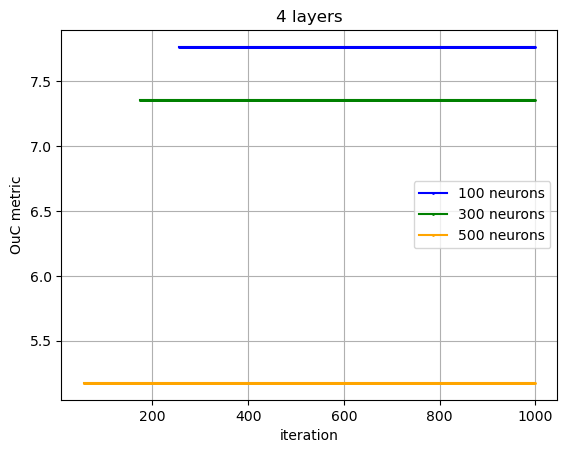

In [32]:
# Plot each dataset with labels
plt.plot(res_1['L_epsilon'], marker='o', linestyle='-', color='blue', label='100 neurons', markersize=1)
plt.plot(res_2['L_epsilon'], marker='o', linestyle='-', color='green', label='300 neurons', markersize=1)
plt.plot(res_3['L_epsilon'], marker='o', linestyle='-', color='orange', label='500 neurons', markersize=1)

# Add labels, title, legend and grid
plt.xlabel('iteration')
plt.ylabel('OuC metric')
plt.title('4 layers')
plt.legend()  # Show the legend to distinguish the datasets
plt.grid(True)
plt.show()

In [33]:
res_3['L_y_T'][-1]

array([ 1.6679057, -2.7510593, -0.8313881,  3.1990714,  3.0314536,
        2.9383523,  3.1322868,  3.2045486,  2.2588317,  2.5000553,
        2.192796 ,  1.9321929,  2.0467918], dtype=float32)

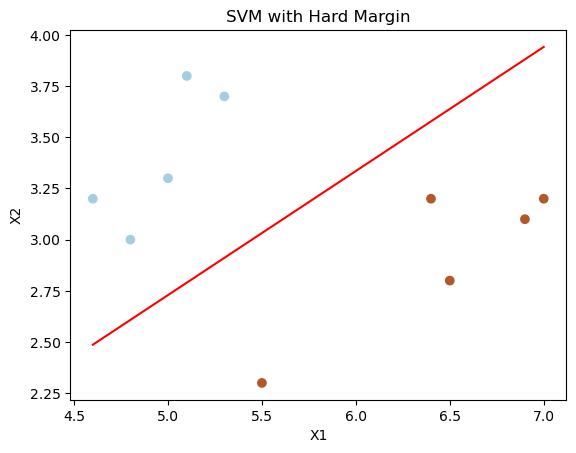

In [36]:
w_pinn = res_3['L_y_T'][-1][:data_X.shape[1]]
b_pinn = res_3['L_y_T'][-1][data_X.shape[1]]

# Plot data points
plt.scatter(data_X[:, 0], data_X[:, 1], c=data_y, cmap=plt.cm.Paired, marker='o')

# Plot the decision boundary
x_plot = np.linspace(np.min(data_X[:, 0]), np.max(data_X[:, 0]), 100)
y_plot = (-w_pinn[0] / w_pinn[1]) * x_plot - b_pinn / w_pinn[1]
plt.plot(x_plot, y_plot, color='r', linestyle='-')

plt.title('SVM with Hard Margin')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [37]:
w_1_abs_diff = np.abs(w_op[0] - w_pinn[0])
w_2_abs_diff = np.abs(w_op[1] - w_pinn[1])
b_abs_diff = np.abs(b_op[0] - b_pinn)

# Calculate the squared differences
w_1_sq_diff = w_1_abs_diff ** 2
w_2_sq_diff = w_2_abs_diff ** 2
b_sq_diff = b_abs_diff ** 2

mse_ = (w_1_sq_diff + w_2_sq_diff + b_sq_diff) / 3

print('w_1 absolute difference:', w_1_abs_diff)
print('w_2 absolute difference:', w_2_abs_diff)
print('b absolute difference:', b_abs_diff)

print('\nMSE between the two solutions:', mse_)

w_1 absolute difference: 0.2393304870103783
w_2 absolute difference: 1.3224908964632025
b absolute difference: 2.7400772588459006

MSE between the two solutions: 3.1047615458950446


In [73]:
t_span = [0, 100]
t_eval = np.linspace(t_span[0], t_span[1], 1000)
sol = solve_ivp(ODE, t_span, y0, method=NUMERICAL_METHOD, t_eval=t_eval)
y_ODE = sol.y

In [74]:
t_torch = torch.tensor(t_eval.reshape((-1, 1)), dtype=torch.float).cuda()

y_nn = net_best(t_torch)
y_nn = y_nn.T.cpu().detach().numpy()

In [59]:
y_ODE.shape

(13, 1000)

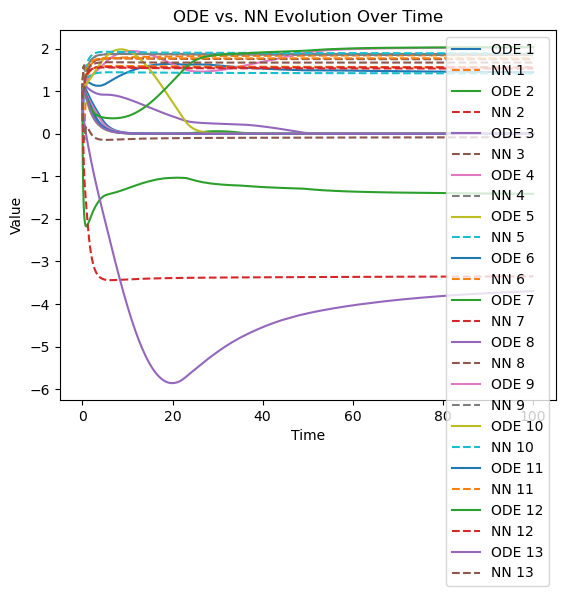

In [20]:
# Create a figure and axes
fig, ax = plt.subplots()

# Iterate and plot
for i in range(y_ODE.shape[0]):
    ax.plot(t_eval, y_ODE[i], label=f'ODE {i+1}')  # Adjust label as needed
    ax.plot(t_eval, y_nn[i], label=f'NN {i+1}', linestyle='--')  # Adjust label and style

# Add labels, legend, and title
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('ODE vs. NN Evolution Over Time')
ax.legend()

# Display the plot
plt.show()